# Data Import

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

# Import our raw data into a Pandas Dataframe
# low_memory is just to make the 'mixed types' warning go away.
df1 = pd.read_csv('delta_public_87_99.csv', low_memory=False)
df2 = pd.read_csv('delta_public_00_12.csv', low_memory=False)

# Combine the 87-99 data with the 00-12 data into one frame
frames = [df1, df2]
data = pd.concat(frames)

## Data Exploration

In [2]:
# Get number of observations and number of attributes
print data.shape

(215613, 974)


In [3]:
# Get some summary statistics of our target variable
display(data['total_enrollment'].describe())

count    153168.000000
mean       2809.486148
std        7540.511589
min           0.000000
25%         101.000000
50%         481.000000
75%        2344.000000
max      380232.000000
Name: total_enrollment, dtype: float64

In [4]:
# Drop rows with missing enrollment data
data = data[np.isfinite(data['total_enrollment'])]
data.shape

(153168, 974)

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,139169.000000,6.296600e+04,68345.000000,151361.000000
mean,2809.486148,593.236129,1.798120e+08,240.711777,2112.358154
std,7540.511589,1456.242667,1.134594e+09,747.546118,5771.201134
min,0.000000,0.000000,-3.721908e+06,0.000000,0.000000
25%,101.000000,56.000000,1.868081e+06,15.000000,87.909080
50%,481.000000,189.000000,1.912804e+07,82.000000,424.714240
75%,2344.000000,544.000000,8.559663e+07,262.000000,1818.719801
max,380232.000000,92011.000000,6.410306e+10,106840.000000,380232.000000


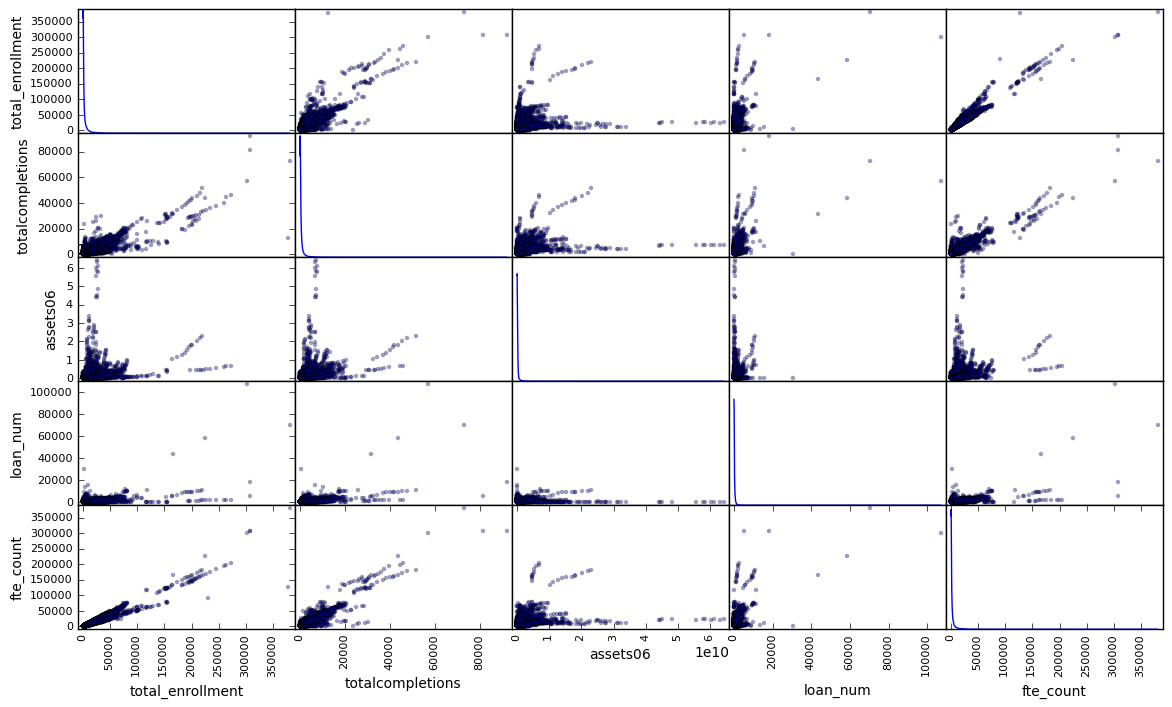

In [5]:
# Produce a scatter matrix for several sample pairs of features in the data
sample_cols = ['total_enrollment', 'totalcompletions', 'assets06', 'loan_num', 'fte_count']
display(data[sample_cols].describe())
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');


In [6]:
# Impute missing data via interpolation
data = data.interpolate()
display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,153168.000000,1.531680e+05,76281.000000,153168.000000
mean,2809.486148,556.438127,1.365838e+08,231.636307,2095.916510
std,7540.511589,1399.547138,8.299817e+08,718.096010,5741.356536
min,0.000000,0.000000,-3.721908e+06,0.000000,0.000000
25%,101.000000,52.000000,3.062782e+06,14.714286,87.349826
50%,481.000000,171.000000,1.853206e+07,79.000000,419.811810
75%,2344.000000,503.000000,6.882778e+07,252.000000,1800.892742
max,380232.000000,92011.000000,6.410306e+10,106840.000000,380232.000000


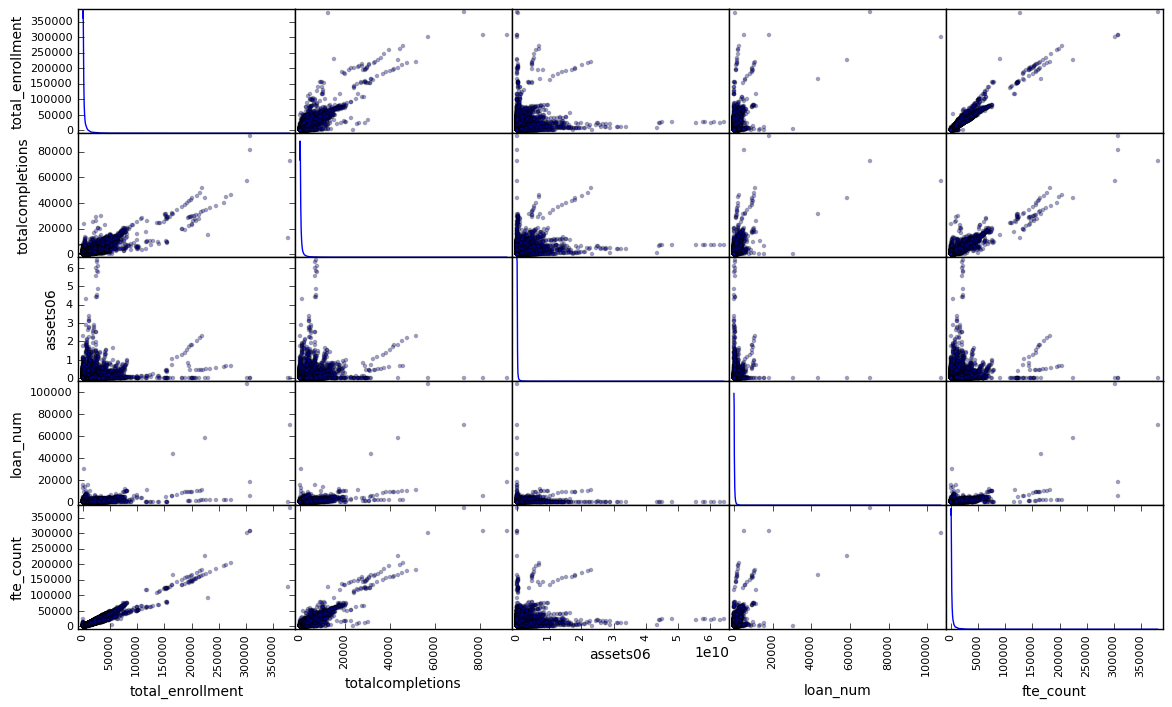

In [7]:
# Produce a scatter matrix for several sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [8]:
# Normalize all floating point columns
float64_columns = list(data.select_dtypes(include=['float64']).columns)

data[float64_columns] = np.log(data[float64_columns])

# the log(0) values were turned into -inf, we want those as zero for normalization
data = data.replace(-np.inf, 0)

display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,fte_count
count,153168.000000,153168.000000,153010.000000,76281.000000,153168.000000
mean,6.178944,5.064608,16.515010,3.906959,5.987060
std,2.055412,1.680453,2.214165,2.173834,1.982229
min,0.000000,-1.609438,0.000000,-2.261763,-1.091427
25%,4.615121,3.951244,14.941336,2.688819,4.469921
50%,6.175867,5.141664,16.737782,4.369448,6.039807
75%,7.759614,6.220590,18.048402,5.529429,7.496038
max,12.848537,11.429663,24.883758,11.579088,12.848537


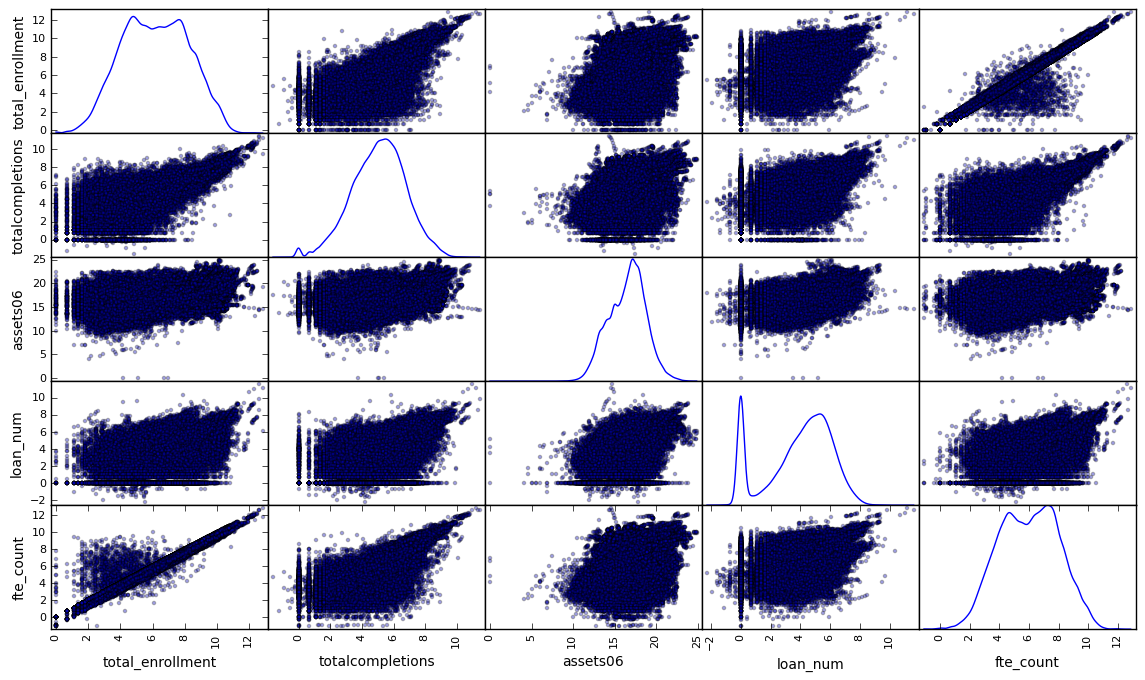

In [9]:
# Produce a scatter matrix for several normalized sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [15]:
# Isolate Target Variable
data = data[float64_columns]
enrollment = data['total_enrollment']
features = data.drop('total_enrollment', axis = 1)

features = features.dropna(axis=1, how='any')
#drop_strings = data.select_dtypes(include=['object']).columns
#features = features.drop(drop_strings, axis = 1)
print features.shape

(153168, 81)


In [17]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=9)
ica.fit(features)

print ica.components_

[[ -1.09632075e-05  -2.50851852e-06   1.25247376e-05  -4.00638938e-06
    9.63257446e-06  -3.93671740e-06  -3.93671740e-06  -5.25308096e-06
   -5.25308096e-06  -4.48246317e-06  -4.48246317e-06  -7.35403572e-06
   -1.21594564e-05  -4.97342025e-05   3.48955727e-05  -2.01508174e-05
    3.02771481e-05   2.72435826e-05   1.78837542e-05  -3.54285130e-05
   -5.66601641e-06  -1.84740361e-05  -3.44841775e-06   1.56598632e-05
   -2.32078314e-06  -1.31839867e-05  -2.39973362e-05  -2.52004857e-05
   -1.50850942e-05   8.46626311e-07  -9.65858183e-06  -2.56575066e-05
   -1.84183808e-05   4.80124994e-05   1.23238249e-05   7.87521925e-07
   -3.09775065e-05  -4.85050803e-05   1.22156627e-04   1.48678851e-05
   -3.28789598e-05  -3.62615900e-05  -2.48154243e-04  -2.56802561e-04
   -5.53069503e-05  -1.57830025e-05  -1.43747032e-05  -1.92152201e-06
   -1.61231267e-05   9.62108416e-05   8.76836189e-05  -3.28224288e-04
   -2.09928901e-05  -2.36818994e-04  -8.60372360e-05  -7.35919993e-05
   -1.37700434e-05  